<a href="https://colab.research.google.com/github/natadekoko68/signate/blob/main/MUFG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount("content/")
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier,RandomForestRegressor
from sklearn.metrics import accuracy_score,mean_squared_error, f1_score
from sklearn.metrics import f1_score as f1s

In [ ]:
card = pd.read_csv("/content/content/MyDrive/Signate_data/2308MUFG/card.csv")
test = pd.read_csv("/content/content/MyDrive/Signate_data/2308MUFG/test.csv")
train = pd.read_csv("/content/content/MyDrive/Signate_data/2308MUFG/train.csv")
user = pd.read_csv("/content/content/MyDrive/Signate_data/2308MUFG/user.csv")
train_num = len(train)
df = pd.concat([train,test],axis=0)
df_merged_temp = pd.merge(df, user, on='user_id', how='left').reset_index(drop=True)
df_merged = pd.merge(df_merged_temp, card, on=["user_id","card_id"], how='left').reset_index(drop=True)

df_merged["amount"] = df_merged["amount"].str[1:].astype(float)
df_merged["per_capita_income_zipcode"] = df_merged["per_capita_income_zipcode"].str[1:].astype(float)
df_merged["yearly_income_person"] = df_merged["yearly_income_person"].str[1:].astype(float)
df_merged["total_debt"] = df_merged["total_debt"].str[1:].astype(float)
df_merged["credit_limit"] = df_merged["credit_limit"].str[1:].astype(float)

df_merged["zip_1"] = df_merged["zip"].astype(str).str[0]
df_merged.loc[~df_merged["zip_1"].str.isdigit() ,"zip_1"] = -1
df_merged["zip_1"] = df_merged["zip_1"].astype(int)
# df_merged["zipcode1"] = df_merged["zipcode"].astype(str).str[0]
# df_merged.loc[~df_merged["zipcode1"].str.isdigit() ,"zipcode1"] = -1
# df_merged["zipcode1"] = df_merged["zipcode"].astype(int)

state_to_region = {
    "AL": "South",
    "AK": "West",
    "AZ": "West",
    "AR": "South",
    "CA": "West",
    "CO": "West",
    "CT": "Northeast",
    "DE": "South",
    "FL": "South",
    "GA": "South",
    "HI": "West",
    "ID": "West",
    "IL": "Midwest",
    "IN": "Midwest",
    "IA": "Midwest",
    "KS": "Midwest",
    "KY": "South",
    "LA": "South",
    "ME": "Northeast",
    "MD": "South",
    "MA": "Northeast",
    "MI": "Midwest",
    "MN": "Midwest",
    "MS": "South",
    "MO": "Midwest",
    "MT": "West",
    "NE": "Midwest",
    "NV": "West",
    "NH": "Northeast",
    "NJ": "Northeast",
    "NM": "West",
    "NY": "Northeast",
    "NC": "South",
    "ND": "Midwest",
    "OH": "Midwest",
    "OK": "South",
    "OR": "West",
    "PA": "Northeast",
    "RI": "Northeast",
    "SC": "South",
    "SD": "Midwest",
    "TN": "South",
    "TX": "South",
    "UT": "West",
    "VT": "Northeast",
    "VA": "South",
    "WA": "West",
    "WV": "South",
    "WI": "Midwest",
    "WY": "West"
}
region_to_number = {
    'Midwest':1,
    'West':2,
    'Northeast':3,
    'South':4,
}


df_merged["us_where"] = df_merged["state"].map(state_to_region)
df_merged["us_where"] = df_merged["us_where"].map(region_to_number)
df_merged["us_where_marchant"] = df_merged["merchant_state"].map(state_to_region)
df_merged["us_where_marchant"] = df_merged["us_where_marchant"].map(region_to_number)
df_merged.loc[df_merged["us_where_marchant"].isna(),"us_where_marchant"] = 5

error={
    "OK": 0,
    "ERROR": 1,
}

df_merged["errors"] = df_merged["errors?"].map(error)

mcc_dic = {}
for i in df_merged["mcc"].unique():
    temp = df_merged[df_merged["mcc"]==i]
    num1 = len(temp[temp["is_fraud?"]==1])
    num2 = len(temp[temp["is_fraud?"]==0])
    mcc_dic[i] = int((num1/num2*100))
df_merged["mcc_rate"] = df_merged["mcc"].map(mcc_dic)

gender = {
    "Male": 0,
    "Female": 1
}

df_merged["gender"] = df_merged["gender"].map(gender)

use_chip = {
    'Swipe Transaction': 1,
    'Chip Transaction': 2,
    'Online Transaction': 3,
}
df_merged["use_chip"] = df_merged["use_chip"].map(use_chip)

df_merged["is_retired"] = df_merged["current_age"] >= df_merged["retirement_age"]

df_merged["current_age_1"] = df_merged["current_age"]//10

df_merged["debt_income_rate"] = df_merged["total_debt"]/df_merged["yearly_income_person"]

has_chip = {}
has_chip_list = list(card.loc[card["has_chip"]=="NO","user_id"])

for i in card["user_id"].unique():
    has_chip[i] = has_chip_list.count(i)

df_merged["has_chip"] = df_merged["user_id"].map(has_chip)

df_merged["per_capita_income_zipcode_qcut"] = pd.cut(df_merged["per_capita_income_zipcode"], 10, labels=False)
df_merged["yearly_income_person_qcut"] = pd.cut(df_merged["yearly_income_person"], 10, labels=False)
df_merged["total_debt_qcut"] = pd.cut(df_merged["total_debt"], 10, labels=False)
df_merged["amount_qcut"] = pd.cut(df_merged["amount"], 5, labels=False)
df_merged["without_chip_rate"] = df_merged["has_chip"]/df_merged["num_credit_cards"]


temp = card[["user_id","year_pin_last_changed"]]
old_pin_changed = {}
max_year = card["year_pin_last_changed"].max()

for row in range(len(temp)):
    user_id = temp.loc[row,"user_id"]
    year = temp.loc[row,"year_pin_last_changed"]
    if user_id in old_pin_changed:
        if old_pin_changed[user_id] > year:
            old_pin_changed[user_id] = year
        else:
            pass
    else:
        old_pin_changed[user_id] = year
df_merged["oldest_pin_changed"] = df_merged["user_id"].map(old_pin_changed)
df_merged["how_long_pin_changed"] = max_year - df_merged["oldest_pin_changed"]

#最新のpin交換
latest_pin_changed = {}
for row in range(len(temp)):
    user_id = temp.loc[row,"user_id"]
    year = temp.loc[row,"year_pin_last_changed"]
    if user_id in latest_pin_changed:
        if latest_pin_changed[user_id] < year:
            latest_pin_changed[user_id] = year
        else:
            pass
    else:
        latest_pin_changed[user_id] = year
df_merged["latest_pin_changed"] = df_merged["user_id"].map(latest_pin_changed)
df_merged["how_long_last_pin_changed"] = max_year - df_merged["latest_pin_changed"]


brands = {'Mastercard':1,
          'Visa':2,
          "Discover":3,
          'Amex':4,
          }
df_merged["card_brand"] = df_merged["card_brand"].map(brands)

types = {'Credit':1,
          'Debit (Prepaid)':2,
          'Debit':3,
          }
df_merged["card_type"] = df_merged["card_type"].map(types)
df_merged["expires"] = df_merged["expires"].astype(str).str[-4:].astype(int)
df_merged["acct_open_date"] = df_merged["acct_open_date"].astype(str).str[-4:].astype(int)

df_merged = df_merged.drop(["merchant_state","city","state","errors?","index","merchant_city","merchant_id","address","zip"],axis=1)
df_merged = df_merged.drop(["zipcode","latitude","longitude","mcc",'current_age', 'retirement_age',"birth_year","birth_month"],axis=1)
df_merged = df_merged.drop(["per_capita_income_zipcode","yearly_income_person","total_debt","amount","us_where","has_chip","oldest_pin_changed","latest_pin_changed"],axis=1)

df_merged.loc[~df_merged["is_fraud?"].isna(),"is_fraud?"] = df_merged.loc[~df_merged["is_fraud?"].isna(),"is_fraud?"].astype(int)

df_merged

,user_id,card_id,is_fraud?,use_chip,gender,fico_score,num_credit_cards,card_brand,card_type,expires,...,is_retired,current_age_1,debt_income_rate,per_capita_income_zipcode_qcut,yearly_income_person_qcut,total_debt_qcut,amount_qcut,without_chip_rate,how_long_pin_changed,how_long_last_pin_changed
0,1721,0,0.0,1,0,732,3,1,1,2021,...,False,6,2.699132,3,3,6,0,0.000000,11,7
1,1629,3,0.0,1,1,797,6,1,2,2022,...,False,5,2.898642,4,3,8,0,0.000000,10,0
2,655,3,0.0,1,0,750,4,1,3,2024,...,False,5,1.485148,5,4,5,0,0.250000,11,4
3,492,0,0.0,2,1,722,4,2,1,2022,...,True,6,0.431657,4,3,1,0,0.250000,10,5
4,1969,4,0.0,1,1,810,7,2,3,2023,...,False,5,1.147763,3,3,2,0,0.142857,12,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
929236,1444,1,NaN,2,0,695,4,1,3,2020,...,False,4,0.935808,2,2,1,0,0.000000,12,3
929237,720,2,NaN,1,1,770,3,1,3,2021,...,False,3,0.721847,2,1,0,0,0.000000,10,4
929238,1773,1,NaN,1,0,638,5,2,1,2021,...,True,7,1.014037,3,2,1,0,0.200000,13,2
929239,156,1,NaN,2,1,731,6,1,3,2021,...,True,8,0.050156,4,3,0,0,0.000000,10,1


<Axes: >

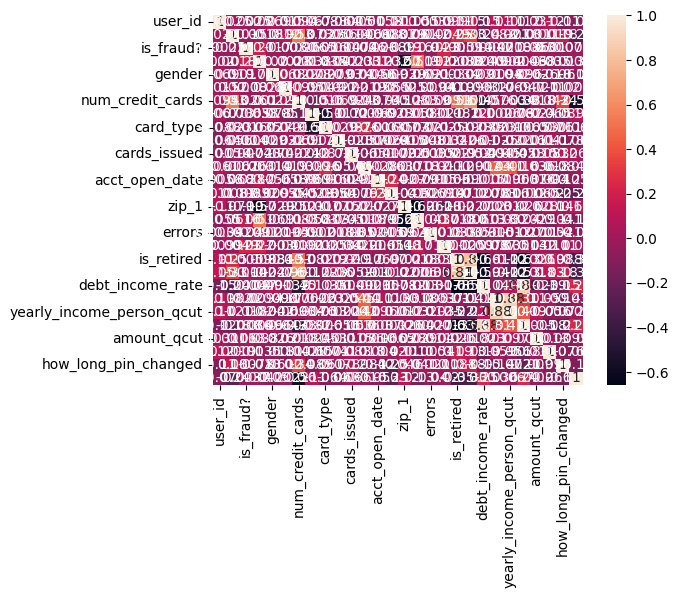

In [ ]:
sns.heatmap(df_merged.corr(), square=True, annot=True)

In [ ]:
df_merged.isna().sum()

user_id                                0
card_id                                0
is_fraud?                         457958
use_chip                               0
gender                                 0
fico_score                             0
num_credit_cards                       0
card_brand                             0
card_type                              0
expires                                0
cards_issued                           0
credit_limit                           0
acct_open_date                         0
year_pin_last_changed                  0
zip_1                                  0
us_where_marchant                      0
errors                                 0
mcc_rate                               0
is_retired                             0
current_age_1                          0
debt_income_rate                       0
per_capita_income_zipcode_qcut         0
yearly_income_person_qcut              0
total_debt_qcut                        0
amount_qcut     

In [ ]:
train = df_merged.loc[0:train_num-1,:]
test = df_merged.loc[train_num:,:]

X = train.drop(["is_fraud?"],axis=1)
y = train["is_fraud?"].astype(int)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf_classifier = RandomForestClassifier(random_state=42)
rf_classifier.fit(X_train, y_train)
y_pred = rf_classifier.predict(X_test)
f1_score = f1s(y_test, y_pred)
print("F1 RFC:", f1_score)

F1 RFC: 0.5448131197559115


In [ ]:
sample_submit = pd.read_csv("/content/content/MyDrive/Signate_data/2308MUFG/sample_submit.csv",header=None)
sub = pd.Series(rf_classifier.predict(test.drop(["is_fraud?"],axis=1))).astype(int)
sample_submit[1] = sub
sample_submit.to_csv("submit2.csv",header=None,index=False)

以下テスト

In [ ]:
from sklearn.metrics import f1_score
train = df_merged.loc[0:train_num-1,:]
test = df_merged.loc[train_num:,:]

X = train.drop(["is_fraud?"],axis=1)
y = train["is_fraud?"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

rf_classifier = RandomForestClassifier(random_state=42)
rf_classifier.fit(X_train, y_train)
y_pred = rf_classifier.predict(X_test)
f1_score = f1_score(y_test, y_pred)
print("F1 RFC:", f1_score)
rf_classifier = RandomForestClassifier(random_state=42)
rf_classifier.fit(X_train, y_train)
y_pred = rf_classifier.predict(X_test)
f1_score = f1_score(y_test, y_pred)
print("F1 RFC:", f1_score)

Accuracy: 0.5290512669416617


In [ ]:
sample_submit = pd.read_csv("/content/content/MyDrive/Signate_data/2308MUFG/sample_submit.csv",header=None)
sub = pd.Series(rf_classifier.predict(test.drop(["is_fraud?"],axis=1))).astype(int)
sample_submit[1] = sub
sample_submit.to_csv("submit2.csv",header=None,index=False)

In [ ]:
df

In [ ]:
import xgboost as xgb
dtrain = xgb.DMatrix(X_train, label=y_train)
dvalid = xgb.DMatrix(X_test, label=y_test)
params = {
        'objective': 'reg:squarederror','silent':1, 'random_state':42,
        # 学習用の指標 (RMSE)
        'eval_metric': 'rmse',
    }
num_round = 500
watchlist = [(dtrain, 'train'), (dvalid, 'eval')]
model = xgb.train(params,
                    dtrain,
                    num_round,
                    early_stopping_rounds=20,
                    evals=watchlist,
                    )
prediction_XG = model.predict(dvalid, ntree_limit = model.best_ntree_limit)
y_pred_proba = model.predict(dvalid)

threshold = 0.5
y_pred = (y_pred_proba >= threshold).astype(int)



[17:29:47] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.

[0]	train-rmse:0.38480	eval-rmse:0.38530
[1]	train-rmse:0.31297	eval-rmse:0.31414
[2]	train-rmse:0.26983	eval-rmse:0.27171
[3]	train-rmse:0.24540	eval-rmse:0.24777
[4]	train-rmse:0.23179	eval-rmse:0.23457
[5]	train-rmse:0.22451	eval-rmse:0.22756
[6]	train-rmse:0.22031	eval-rmse:0.22363
[7]	train-rmse:0.21767	eval-rmse:0.22125
[8]	train-rmse:0.21585	eval-rmse:0.21963
[9]	train-rmse:0.21460	eval-rmse:0.21850
[10]	train-rmse:0.21385	eval-rmse:0.21788
[11]	train-rmse:0.21321	eval-rmse:0.21733
[12]	train-rmse:0.21246	eval-rmse:0.21672
[13]	train-rmse:0.21199	eval-rmse:0.21624
[14]	train-rmse:0.21087	eval-rmse:0.21533
[15]	train-rmse:0.21003	eval-rmse:0.21461
[16]	train-rmse:0.20968	eval-rmse:0.21430
[17]	train-rmse:0.20938	eval-rmse:0.21405
[18]	train-rmse:0.20861	eval-rmse:0.21341
[19]	train-rmse:0.20799	eval-rmse:0.21297
[20]	train-rmse:0.20743	eval-rmse:0.21249
[21]	train-rmse:0.20713	eval-rmse:0.21230
[2

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


TypeError: ignored

In [ ]:
y_pred_proba = model.predict(dvalid)

threshold = 0.5
y_pred = (y_pred_proba >= threshold).astype(int)



0         0
1         0
2         0
3         0
4         0
         ..
141380    0
141381    0
141382    0
141383    0
141384    0
Length: 141385, dtype: int64

In [ ]:
XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=-1, num_parallel_tree=None,
              objective='binary:logistic', predictor=None, ...)

#めも

	Model	Accuracy	AUC	Recall	Prec.	F1	Kappa	MCC	TT (Sec)
xgboost	Extreme Gradient Boosting	0.9521	0.8965	0.4047	0.8081	0.5393	0.5170	0.5516	4.3360
lightgbm	Light Gradient Boosting Machine	0.9488	0.8769	0.3367	0.8152	0.4765	0.4544	0.5041	5.0880
rf	Random Forest Classifier	0.9446	0.8628	0.4567	0.6400	0.5330	0.5044	0.5126	45.0400
gbc	Gradient Boosting Classifier	0.9415	0.8270	0.2142	0.7828	0.3363	0.3160	0.3906	54.7020
knn	K Neighbors Classifier	0.9401	0.7680	0.3086	0.6408	0.4164	0.3889	0.4181	100.2140
et	Extra Trees Classifier	0.9370	0.8339	0.4727	0.5531	0.5097	0.4763	0.4780	34.5010
ada	Ada Boost Classifier	0.9358	0.8046	0.1213	0.7135	0.2072	0.1909	0.2767	14.1190
lr	Logistic Regression	0.9320	0.7708	0.0787	0.5619	0.1381	0.1231	0.1920	11.5720
ridge	Ridge Classifier	0.9309	0.0000	0.0097	0.5370	0.0191	0.0167	0.0651	0.7810
dummy	Dummy Classifier	0.9308	0.5000	0.0000	0.0000	0.0000	0.0000	0.0000	0.3680
lda	Linear Discriminant Analysis	0.9264	0.7867	0.2223	0.4383	0.2949	0.2604	0.2773	1.6650
dt	Decision Tree Classifier	0.9228	0.7114	0.4660	0.4450	0.4552	0.4137	0.4138	3.3850
nb	Naive Bayes	0.8964	0.7609	0.3220	0.2826	0.3010	0.2453	0.2460	0.6320
qda	Quadratic Discriminant Analysis	0.8787	0.7870	0.4645	0.2764	0.3465	0.2844	0.2961	1.7280
svm	SVM - Linear Kernel	0.8725	0.0000	0.1776	0.3765	0.1242	0.0907	0.1338	30.0930


In [ ]:
sample_submit = pd.read_csv("/content/content/MyDrive/Signate_data/2308MUFG/sample_submit.csv",header=None)
sample_submit[1] = pd.Series(y_pred)
sample_submit.to_csv("submit3.csv",header=None,index=False)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, f1_score
rf_classifier = RandomForestClassifier(random_state=1)
scorer = make_scorer(f1_score)
f1_scores = cross_val_score(rf_classifier, X, y, cv=5, scoring=scorer)
print("F1 Scores for each fold:", f1_scores)
average_f1 = f1_scores.mean()
print("Average F1 Score:", average_f1)

Average F1 Score: 0.5115867731428873


In [ ]:
print("詐欺　利用額:", df_merged[df_merged["is_fraud?"] == 1]["amount"].mean())
print("非詐欺 利用額:", df_merged[df_merged["is_fraud?"] == 0]["amount"].mean())

詐欺　利用額: 116.45978339615702
非詐欺 利用額: 63.19539509451683


0.09140300415468201
10.94055944055944
0.1050656660412758
9.517857142857142
0.07799409558764861
12.82148337595908
0.06454815178352333
15.492310350786244
0.07594579333709768
13.16728624535316
0.07948589834904908
12.580847933663234
0.0718450281316503
13.91884763643741
0.08429328944962516
11.863340563991324
0.07658932970548223
13.056649063850216
0.05481615159034514
18.242798353909464
0.06200810875268304
16.126923076923077


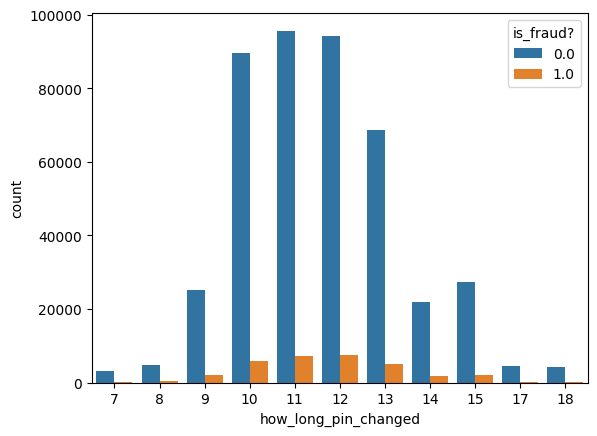

In [ ]:
sns.countplot(x='how_long_pin_changed', hue="is_fraud?", data=df_merged)

for i in range(20):
    a = (df_merged[df_merged["how_long_pin_changed"]==i]["is_fraud?"]==1).sum()
    b = (df_merged[df_merged["how_long_pin_changed"]==i]["is_fraud?"]==0).sum()
    if b >= 1:
        print(a/b)
    if a >= 1:
        print(b/a)


<Axes: xlabel='card_id', ylabel='count'>

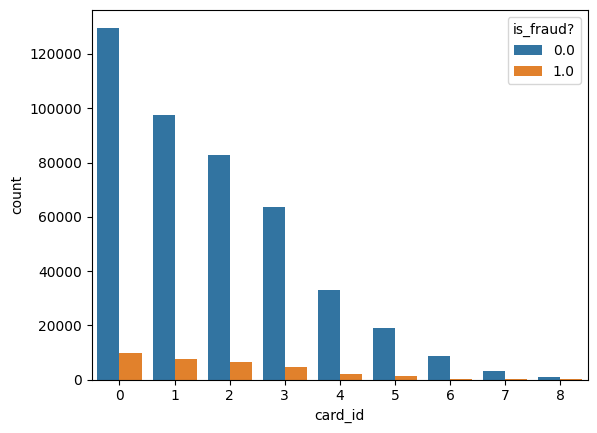

In [ ]:
sns.countplot(x='card_id', hue="is_fraud?", data=df_merged)

<Axes: xlabel='amount', ylabel='count'>

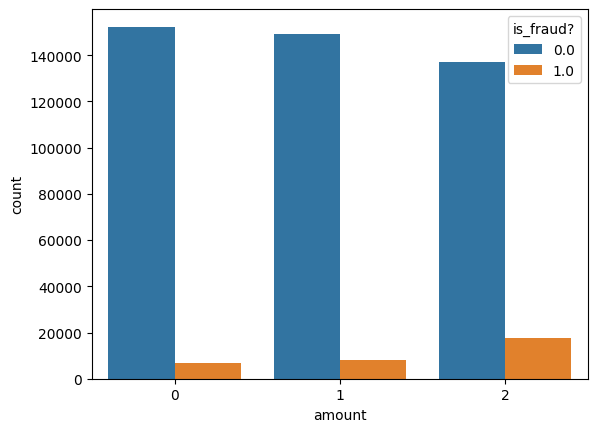

In [ ]:
df_merged2 = df_merged.copy()
n = 3
df_merged2["amount"] = pd.qcut(df_merged2["amount"],n,labels=False)
sns.countplot(x='amount', hue="is_fraud?", data=df_merged2)

9 0.09273697168649979
10 0.07641079565369786
11 0.08022181146025878
12 0.08487759815242495
13 0.06892061976476715
14 0.07403627704681026
15 0.07108898136125226
16 0.07827847547128512
17 0.06863429968564443


<Axes: xlabel='fico_score', ylabel='count'>

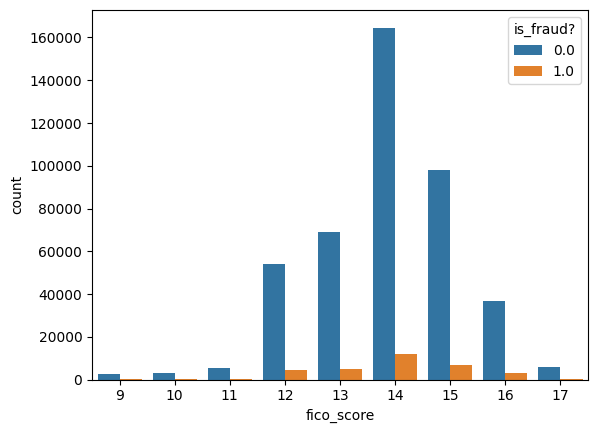

In [ ]:
df_merged2 = df_merged.copy()
df_merged2['fico_score'] = df_merged2['fico_score']//
df_merged2['fico_score'].unique()
dev = []
for i in range(1,100):
    num1 = (df_merged2.loc[df_merged2['fico_score']==i,"is_fraud?"]==1).sum()
    num2 = (df_merged2.loc[df_merged2['fico_score']==i,"is_fraud?"]==0).sum()
    if num1>0 and num2>0:
        print(i, num1/num2)
        dev.append(num1/num2)
sns.countplot(x='fico_score', hue="is_fraud?", data=df_merged2)

<Axes: xlabel='birth_month', ylabel='count'>

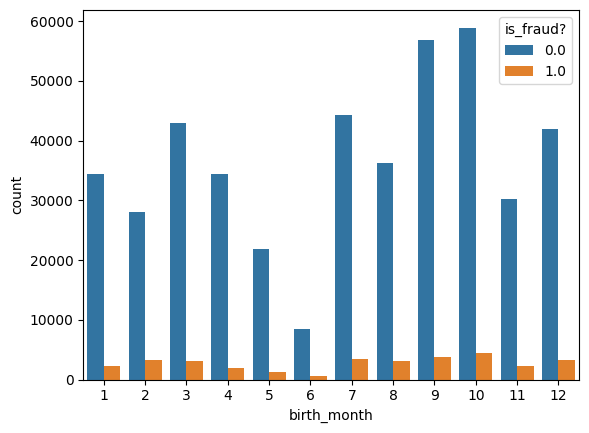

In [ ]:

sns.countplot(x='birth_month', hue="is_fraud?", data=df_merged)

In [ ]:
for i in range(1,13):
    num1 = (df_merged.loc[df_merged['birth_month']==i,"is_fraud?"]==1).sum()
    num2 = (df_merged.loc[df_merged['birth_month']==i,"is_fraud?"]==0).sum()
    print(i, num1/num2)

1 0.06552416421775437
2 0.11923008376403493
3 0.07324455205811138
4 0.056046768658018734
5 0.05924908424908425
6 0.07754575316752699
7 0.07617931438617052
8 0.08365796380715569
9 0.06606791338582677
10 0.07412748774156332
11 0.07454280413464087
12 0.07676353493694424
